This is an example of developing a script locally with the West Nile Virus data to share on Kaggle
Once you have a script you're ready to share, paste your code into a [new script](https://www.kaggle.com/c/predict-west-nile-virus/scripts/new).

# West Nile Monthly EDA

This notebook is for EDA & visualzation purposes and will thus only contain training dataset

In [55]:
# For working locally, you want to be in west_nile_scripts/working. 
# This command will move you to there, if you're in west_nile_scripts/src (where this file is).
!cd ../working/ # Not necessary for scripts running on Kaggle

In [118]:
# Code is borrowed from: https://www.kaggle.com/users/213536/vasco/predict-west-nile-virus/west-nile-heatmap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
#Remove this when copying to a script on Kaggle:
%matplotlib inline
import datetime as dt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [119]:
mapdata = np.loadtxt("../input/mapdata_copyright_openstreetmap_contributors.txt")
traps = pd.read_csv('../input/train.csv')[['Date', 'Species','Street','Trap','Longitude',
                                           'Latitude', 'NumMosquitos','WnvPresent']]
Train = pd.read_csv('../input/train.csv')
weather = pd.read_csv('../input/weather.csv').drop(["Depth", "Water1","SnowFall","CodeSum",
                                                    "SeaLevel", "ResultDir", "StnPressure"], 1)
spray = pd.read_csv('../input/spray.csv')

In [120]:
# There are multiple traps locations for a given trap, like T009 & T035
# Sum up NumMosquitoes and WnvPresent
trap_locations = traps.loc[:,["Street","Trap","Longitude","Latitude"]].drop_duplicates()
trap_group = traps.loc[:,
                       ["Street","Date","Species","Trap",
                        "NumMosquitos","WnvPresent"]].groupby(
                        ["Street","Date","Species","Trap"]).agg("sum").reset_index()
traps = trap_group.merge(trap_locations,on=["Street","Trap"],how="inner")

In [121]:
# Create new identifier for traps that have multiple locations
# Specifically, traps T009 and T035, append "A" to it
traps["Street_trap"] = traps.Street + "," + traps.Trap
traps.Street_trap = traps.Street_trap.map(lambda x: x.split(","))
traps.Street_trap = traps.Street_trap.map(
    lambda x: x[1] if ((x[0] != " W HIGGINS RD") & (x[0] != " W 72ND ST")) else (x[1] + "A"))
traps.Trap = traps.Street_trap
traps = traps.drop(["Street","Street_trap"],1)

In [122]:
# Convert traps that had multiple Wnv detections to just 1 (binary)
traps.WnvPresent =  traps.WnvPresent.map(lambda x: 1 if x > 1 else x)

In [64]:
len(traps.Trap.unique())

138

## Traps data cleaning

In [65]:
# Traps df cleaning
# Convert to date to date time
traps.Date = pd.to_datetime(traps.Date)
weather.Date = pd.to_datetime(weather.Date)

# Weather df cleaning
# Converts T(trace) to low value of 0.001, and converts "M" (missing data) to NaN
weather["PrecipTotal"] = pd.to_numeric(weather.PrecipTotal.str.strip().replace("T",0.001),
                                      errors="coerce")
# Depart, Cool, Sunrise & Sunset, and PrecipTotal have Missing values
# Convert to numeric first, then forward fill NaN
for i in range(2,len(weather.columns)):
    weather.iloc[:, i] = pd.to_numeric(weather.iloc[:, i], errors="coerce")
# Impute missing values for the weather with forward fill()
weather.fillna(method='ffill',inplace=True)

In [66]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,PrecipTotal,ResultSpeed,AvgSpeed
0,1,2007-05-01,83,50,67.0,14.0,51,56.0,0.0,2.0,448.0,1849.0,0.0,1.7,9.2
1,2,2007-05-01,84,52,68.0,14.0,51,57.0,0.0,3.0,448.0,1849.0,0.0,2.7,9.6
2,1,2007-05-02,59,42,51.0,-3.0,42,47.0,14.0,0.0,447.0,1850.0,0.0,13.0,13.4
3,2,2007-05-02,60,43,52.0,-3.0,42,47.0,13.0,0.0,447.0,1850.0,0.0,13.3,13.4
4,1,2007-05-03,66,46,56.0,2.0,40,48.0,9.0,0.0,446.0,1851.0,0.0,11.7,11.9


In [67]:
def closer_station(lat,long):
    loc = np.array([lat,long])
    # station 1: [41.995, -87.933], station 2: [41.786, -87.752]
    stations = np.array([[41.995, -87.933],
                         [41.786, -87.752]])
    # get the station # with the lower distance squared
    return np.argmin(((stations-loc[None,:])**2).sum(1))+1

In [68]:
def merge_station(traps):
    station_list= []
    for i in range(len(traps)):
        station_dict = {'Trap':traps.loc[i, "Trap"],'Station': closer_station(
                traps.loc[i,"Latitude"], traps.loc[i, "Longitude"])}
        if station_dict not in station_list:
            station_list.append(station_dict) 
    return traps.merge(pd.DataFrame(station_list),on="Trap",how="inner")
trap_stations = merge_station(traps)

In [69]:
trap_stations.head()

,Date,Species,Trap,NumMosquitos,WnvPresent,Longitude,Latitude,Station
0,2007-06-05,CULEX PIPIENS/RESTUANS,T151,1,0,-87.800515,41.916265,2
1,2007-06-05,CULEX RESTUANS,T151,10,0,-87.800515,41.916265,2
2,2007-06-26,CULEX PIPIENS/RESTUANS,T151,3,0,-87.800515,41.916265,2
3,2007-06-26,CULEX RESTUANS,T151,6,0,-87.800515,41.916265,2
4,2007-06-29,CULEX PIPIENS/RESTUANS,T151,1,0,-87.800515,41.916265,2


In [70]:
merged = trap_stations.merge(weather,on=["Date","Station"],how="inner")
merged = merged.drop(["Station"],1)

In [71]:
merged['Month'] = merged['Date'].map(lambda x: x.month)
merged['Year'] = merged['Date'].map(lambda x: x.year)
merged['Dry'] = merged['DewPoint'].subtract(merged.WetBulb)
merged['Week'] = merged['Date'].map(lambda x: x.isocalendar()[1])
#random forest depth

In [72]:
#Risk if month between 7 and 9 <- when WNV is active
merged['risk'] = merged['Date'].map(lambda x: 1 
                                    if (x.month > 6) and (x.month < 9) else 0)

In [73]:
merged.Tmax = merged.Tmax.astype('float')
merged.Tmin = merged.Tmin.astype('float')
merged.DewPoint = merged.DewPoint.astype('float')
merged.Week = merged.Week.astype('str')
merged.Month = merged.Month.astype('str')
merged.Year = merged.Year.astype('str')

In [74]:
merged.dtypes

Date            datetime64[ns]
Species                 object
Trap                    object
NumMosquitos             int64
WnvPresent               int64
Longitude              float64
Latitude               float64
Tmax                   float64
Tmin                   float64
Tavg                   float64
Depart                 float64
DewPoint               float64
WetBulb                float64
Heat                   float64
Cool                   float64
Sunrise                float64
Sunset                 float64
PrecipTotal            float64
ResultSpeed            float64
AvgSpeed               float64
Month                   object
Year                    object
Dry                    float64
Week                    object
risk                     int64
dtype: object

In [75]:
# mapper3 = DataFrameMapper([
#     (["Tmax","Tmin","Tavg","Depart","DewPoint",
#       "WetBulb","Heat","Cool","Sunrise","Sunset","PrecipTotal",
#       "ResultSpeed","AvgSpeed","Dry"], sklearn.preprocessing.StandardScaler())]
# ,input_df=True,df_out=True)
# #mapper3.fit_transform(merged.copy())

In [76]:
# def normalize(df,features):
#     result = df.copy()
#     for feature_name in features:
#         mean_val = df[feature_name].mean()
#         std_val = df[feature_name].std()
#         result[feature_name] = (df[feature_name] - mean_val) / (std_val)
#     return result
# merged_n = normalize(merged,["Tmax","Tmin","Tavg","Depart","DewPoint",
#       "WetBulb","Heat","Cool","Sunrise","Sunset","PrecipTotal",
#       "ResultSpeed","AvgSpeed","Dry"])

In [77]:
#merged.to_csv("merged.csv")
#merged.to_pickle("merged.pkl")
#merged_test.to_pickle("merged_test.pkl")
# merged_n.to_pickle("merged_n.pkl")
# merged_ntest.to_pickle("merged_ntest.pkl")

In [78]:
merged.NumMosquitos.describe()

count    8475.000000
mean       15.933805
std        75.084707
min         1.000000
25%         2.000000
50%         4.000000
75%        11.000000
max      2532.000000
Name: NumMosquitos, dtype: float64

# Generate Time Lag

In [79]:
# # Make deep copies of stations with different time lags
# days_ago = [0,1,2,3,4,5,6,7,8,9,14]
# station_list = []
# merged_list = []
# for i in range(len(days_ago)):
#     station_list.append(trap_stations.copy())
# for i in range(len(days_ago)):
#     station_list[i].Date = station_list[i].Date - dt.timedelta(days = days_ago[i])
# for station in station_list:
#     merged_list.append(station.merge(weather,on=["Date","Station"],how="inner"))

In [80]:
merged = pd.read_pickle("merged.pkl")
merged_test = pd.read_pickle("merged_test.pkl")

# Modeling

In [81]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn import metrics

/Users/petermin/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [82]:
merged.dtypes

Date            datetime64[ns]
Species                 object
Trap                    object
NumMosquitos             int64
WnvPresent               int64
Longitude              float64
Latitude               float64
Tmax                   float64
Tmin                   float64
Tavg                   float64
Depart                 float64
DewPoint               float64
WetBulb                float64
Heat                   float64
Cool                   float64
Sunrise                float64
Sunset                 float64
PrecipTotal            float64
ResultSpeed            float64
AvgSpeed               float64
Month                   object
Year                    object
Dry                    float64
Week                    object
risk                     int64
dtype: object

## Linear Regression to predict #Mosquitoes

In [83]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import normalize

In [84]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    model.fit(xtrain, ytrain)
    return model.score(xtest, ytest)

def quick_test_afew_times(model, X, y, n=10):
    return np.mean([quick_test(model, X, y) for j in range(n)])

def stdscaler(X,y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    xtrain = StandardScaler.fit(xtrain)
    xtrain = StandardScaler.fit_transform(xtrain)
    xtest = StandardScaler.fit_transform(ytrain)
    
#    xtest = 


In [85]:
merged = pd.read_pickle("merged.pkl")

In [86]:
merged.columns

Index(['Date', 'Species', 'Trap', 'NumMosquitos', 'WnvPresent', 'Longitude',
       'Latitude', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'Sunrise', 'Sunset', 'PrecipTotal', 'ResultSpeed',
       'AvgSpeed', 'Month', 'Year', 'Dry', 'Week', 'risk'],
      dtype='object')

In [87]:
# merged3 = pd.get_dummies(merged,columns=["Species","Trap","Month","Week"]).drop(["Date"],1)
# merged3 = normalize(merged3["Tmax","Tmin","Tavg","Depart","Dewpoint",
#                            "WetBulb","Heat","Cool","Sunrise","Sunset","PrecipTotal",
#                            "ResultSpeed","AvgSpeed","Dry"])
#merged3 = pd.get_dummies(merged,columns=["Species","Trap"]).drop(["Date","NumMosquitos"],1)
# merged_2013 = merged3[merged3.Year == "2013"]
# merged_train = merged3[merged3.Year != "2013"] 
# y_2013 = merged_2013.NumMosquitos
# X_2013 = merged_2013.drop(["NumMosquitos"],1)
# merged3 = merged.drop(["Date", "Year", "Trap"],1)
merged3 = pd.get_dummies(merged,columns=[
    "Species","Month","Week"]).drop(["Trap","Date","Year"],1)
y = merged3.NumMosquitos
X = merged3.drop(["NumMosquitos"],1)
Xt, Xhold, yt, yhold = train_test_split(X, y, test_size=0.3)

In [88]:
# Polyfit model with elastic net
alphas = [1e-3,1e-2,1e-1,1,10,100,300]
l1 = [0.01, .1, .5, .7, .9, .99, 1]
degree = 2
poly_model = make_pipeline(ElasticNetCV(alphas=alphas, l1_ratio = l1,cv=8,max_iter = 2000))
poly_model.fit(Xt,yt)
print("alpha =", poly_model.named_steps.elasticnetcv.alpha_)
print("l1_ratio =", poly_model.named_steps.elasticnetcv.l1_ratio_)
print("R^2 on CV =", poly_model.score(X_2013,y_2013))

/Users/petermin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha = 0.1
l1_ratio = 1.0


NameError: name 'X_2013' is not defined

In [ ]:
from sklearn import tree
#Xtrain, Xval, ytrain, yval = train_test_split(Xt, yt, test_size=0.2)
# clf = tree.DecisionTreeRegressor(max_depth=20)
# clf.fit(Xtrain,ytrain)
# clf.score(Xval,yval)
# linearsvc = LinearSVC()
# Do the test 10 times with a LinearSVC and get the average score
#quick_test_afew_times(tree.DecisionTreeClassifier(max_depth=20), Xt, yt)

DecTree = make_pipeline(StandardScaler(),tree.DecisionTreeRegressor(max_depth=10))
DecTree.fit(Xt, yt)
DecTree.score(Xhold,yhold)

In [ ]:
clf.score(Xval,yval)

## other models

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
#cross_val_score(scoring=‘roc_auc’)
depth_range = list(range(3, 40))
param_grid = dict(max_depth=depth_range)
grid = GridSearchCV(RandomForestClassifier(class_weight={0:18.06,1:1}), param_grid,
                    n_jobs=-1, scoring='roc_auc',
                    cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=1))


In [ ]:
grid.fit(Xt3,yt3);
#param_grid

In [ ]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

In [ ]:
print(cross_val_score(RandomForestClassifier(max_depth=8,class_weight={0:18.06,1:1}), Xt3, yt3, 
                      cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=5)
                      , scoring='roc_auc').mean())

In [ ]:
from sklearn.metrics import roc_auc_score
pred3 = grid.predict(Xhold3)
#fpr, tpr,_ = roc_curve(yt, pred)
roc_auc_score(yhold3, pred3)

In [ ]:
merged = pd.read_pickle("merged.pkl")
merged.columns
#merged2_test.columns

### Catboost

In [117]:
merged[merged.WnvPresent == 1]

,Date,Species,Trap,NumMosquitos,WnvPresent,Longitude,Latitude,Tmax,Tmin,Tavg,...,Sunrise,Sunset,PrecipTotal,ResultSpeed,AvgSpeed,Month,Year,Dry,Week,risk
307,2007-07-18,CULEX PIPIENS/RESTUANS,T215,63,1,-87.531635,41.686398,85.0,69.0,77.0,...,432.0,1924.0,0.920,10.3,10.6,7,2007,-2.0,29,1
472,2007-08-01,CULEX PIPIENS/RESTUANS,T220,2,1,-87.691810,41.963976,91.0,69.0,80.0,...,445.0,1911.0,0.000,2.1,3.7,8,2007,-7.0,31,1
510,2007-08-01,CULEX PIPIENS/RESTUANS,T090,61,1,-87.666901,41.868077,91.0,69.0,80.0,...,445.0,1911.0,0.000,2.1,3.7,8,2007,-7.0,31,1
519,2007-08-01,CULEX PIPIENS/RESTUANS,T103,378,1,-87.536497,41.702724,91.0,69.0,80.0,...,445.0,1911.0,0.000,2.1,3.7,8,2007,-7.0,31,1
542,2007-08-01,CULEX PIPIENS/RESTUANS,T081,20,1,-87.627796,41.821582,91.0,69.0,80.0,...,445.0,1911.0,0.000,2.1,3.7,8,2007,-7.0,31,1
596,2007-08-01,CULEX PIPIENS/RESTUANS,T138,219,1,-87.585413,41.726465,91.0,69.0,80.0,...,445.0,1911.0,0.000,2.1,3.7,8,2007,-7.0,31,1
601,2007-08-01,CULEX PIPIENS/RESTUANS,T082,69,1,-87.642984,41.803423,91.0,69.0,80.0,...,445.0,1911.0,0.000,2.1,3.7,8,2007,-7.0,31,1
608,2007-08-01,CULEX PIPIENS/RESTUANS,T086,223,1,-87.676709,41.688324,91.0,69.0,80.0,...,445.0,1911.0,0.000,2.1,3.7,8,2007,-7.0,31,1
613,2007-08-01,CULEX PIPIENS,T135,67,1,-87.724608,41.662014,91.0,69.0,80.0,...,445.0,1911.0,0.000,2.1,3.7,8,2007,-7.0,31,1
614,2007-08-01,CULEX PIPIENS/RESTUANS,T135,89,1,-87.724608,41.662014,91.0,69.0,80.0,...,445.0,1911.0,0.000,2.1,3.7,8,2007,-7.0,31,1


In [112]:
# merged3 = pd.get_dummies(merged,columns=[
#     "Species","Month","Week"]).drop(["Trap","Date","NumMosquitos","Year"],1)

merged2 = merged.drop(["Date", "Year", "NumMosquitos","Trap"],1)
# Reorder columns
cols = ["Month","Week","Longitude","Latitude","Tmax","Tmin","Tavg","Depart","DewPoint",
       "WetBulb","Heat","Cool","Sunrise","Sunset","PrecipTotal","ResultSpeed","AvgSpeed",
       "Month","Dry","risk","WnvPresent"]
merged2 = merged2[cols]
y = merged2.WnvPresent
X = merged2.drop(["WnvPresent"],1)
y3 = merged3.WnvPresent
X3 = merged3.drop(["WnvPresent"],1)
# Split by year
Xt, Xhold, yt, yhold = train_test_split(X, y, test_size=0.2, stratify=y,random_state=1234)
Xt3, Xhold3, yt3, yhold3 = train_test_split(X3, y3, test_size=0.2, stratify=y3,random_state=1234)

In [113]:
X.columns

Index(['Month', 'Week', 'Longitude', 'Latitude', 'Tmax', 'Tmin', 'Tavg',
       'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset',
       'PrecipTotal', 'ResultSpeed', 'AvgSpeed', 'Month', 'Dry', 'risk'],
      dtype='object')

In [114]:
# merged3 = pd.get_dummies(merged,columns=["Species","Trap"]).drop(["Date","NumMosquitos"],1)
# merged2 = merged.drop(["Date","NumMosquitos"],1)
# merged2_test = merged_test.drop(["Date"],1)
# y = merged2.WnvPresent
# X = merged2.drop(["WnvPresent"],1)
# # Split by year
# merged_2013 = merged3[merged3.Year == "2013"]
# merged_train = merged3[merged3.Year != "2013"] 
# yt = merged_train.NumMosquitos
# Xt = merged_train.drop(["NumMosquitos"],1)
# y_2013 = merged_2013.NumMosquitos
# X_2013 = merged_2013.drop(["NumMosquitos"],1)

In [115]:
print(Xt.dtypes)

#categorical_features_indices = np.where((Xt.dtypes != np.float) & (Xt.dtypes != np.int64))[0]
categorical_features_indices = np.where(Xt.dtypes == object)[0]
print(categorical_features_indices)

Month           object
Week            object
Longitude      float64
Latitude       float64
Tmax           float64
Tmin           float64
Tavg           float64
Depart         float64
DewPoint       float64
WetBulb        float64
Heat           float64
Cool           float64
Sunrise        float64
Sunset         float64
PrecipTotal    float64
ResultSpeed    float64
AvgSpeed       float64
Month           object
Dry            float64
risk             int64
dtype: object
[ 0  1 17]


In [116]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score
xtrain, xtest, ytrain, ytest = train_test_split(
    Xt, yt, test_size=0.3,stratify=yt,random_state=1234)
model = CatBoostClassifier(eval_metric="AUC",iterations=100, depth=10, learning_rate=0.1,
                           class_weights = [1, 18.06],)
model.fit(
    xtrain, ytrain,
    cat_features=categorical_features_indices,
    eval_set=(xtest, ytest),
#     logging_level='Verbose',  # you can uncomment this for text output
#    plot=True
);

0:	learn: 0.8004733	test: 0.7760702	best: 0.7760702 (0)	total: 137ms	remaining: 13.6s
1:	learn: 0.8183629	test: 0.7545644	best: 0.7760702 (0)	total: 194ms	remaining: 9.49s
2:	learn: 0.8334189	test: 0.7696796	best: 0.7760702 (0)	total: 333ms	remaining: 10.8s
3:	learn: 0.8273990	test: 0.7716712	best: 0.7760702 (0)	total: 374ms	remaining: 8.97s
4:	learn: 0.8237111	test: 0.7700269	best: 0.7760702 (0)	total: 421ms	remaining: 8.01s
5:	learn: 0.8214996	test: 0.7690772	best: 0.7760702 (0)	total: 491ms	remaining: 7.69s
6:	learn: 0.8246972	test: 0.7720043	best: 0.7760702 (0)	total: 625ms	remaining: 8.3s
7:	learn: 0.8316189	test: 0.7805708	best: 0.7805708 (7)	total: 753ms	remaining: 8.66s
8:	learn: 0.8521828	test: 0.7959648	best: 0.7959648 (8)	total: 955ms	remaining: 9.65s
9:	learn: 0.8581409	test: 0.7946560	best: 0.7959648 (8)	total: 1.2s	remaining: 10.8s
10:	learn: 0.8635936	test: 0.7958066	best: 0.7959648 (8)	total: 1.5s	remaining: 12.1s
11:	learn: 0.8671544	test: 0.7997283	best: 0.7997283 (11

94:	learn: 0.9001718	test: 0.8166580	best: 0.8166580 (94)	total: 9.8s	remaining: 516ms
95:	learn: 0.9001727	test: 0.8166580	best: 0.8166580 (94)	total: 9.93s	remaining: 414ms
96:	learn: 0.9014925	test: 0.8157508	best: 0.8166580 (94)	total: 10.2s	remaining: 316ms
97:	learn: 0.9037379	test: 0.8147940	best: 0.8166580 (94)	total: 10.6s	remaining: 216ms
98:	learn: 0.9063005	test: 0.8165800	best: 0.8166580 (94)	total: 10.8s	remaining: 109ms
99:	learn: 0.9072448	test: 0.8178416	best: 0.8178416 (99)	total: 11s	remaining: 0us

bestTest = 0.8178416178
bestIteration = 99

Shrink model to first 100 iterations.


In [110]:
train_pool = Pool(xtrain,ytrain,categorical_features_indices)
feature_imp = model.get_feature_importance(train_pool)
feature_names = xtrain.columns
for score, name in sorted(zip(feature_imp, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

Sunrise: 20.06161671144384
Month: 15.852465943446111
Sunset: 12.106336600804605
Month: 8.629122999457914
Species: 7.227323655512756
Depart: 5.452040595515502
WetBulb: 3.5663766615078982
DewPoint: 3.2161795297196565
Longitude: 3.106566387866773
AvgSpeed: 2.927646046019947
Latitude: 2.5521380200906876
Tavg: 2.4865848803713795
Cool: 2.264772991076389
Dry: 2.1027750232049462
Tmax: 2.0192340858857976
Week: 1.9168973059839112
ResultSpeed: 1.8455196289886324
Tmin: 1.0869934176819809
Heat: 0.777646768976634
PrecipTotal: 0.6265810864632688
risk: 0.1751816599813666


In [364]:
# cv_data = cv(
#     Pool(Xt, yt, cat_features=categorical_features_indices),
#     model.get_params(),
#     stratified=True,
#     nfold=8,
# #    plot=True
# )

In [111]:
pred = model.predict(Xhold)
roc_auc_score(yhold, pred)

0.7727898659943547

Text(0,0.5,'TPR')

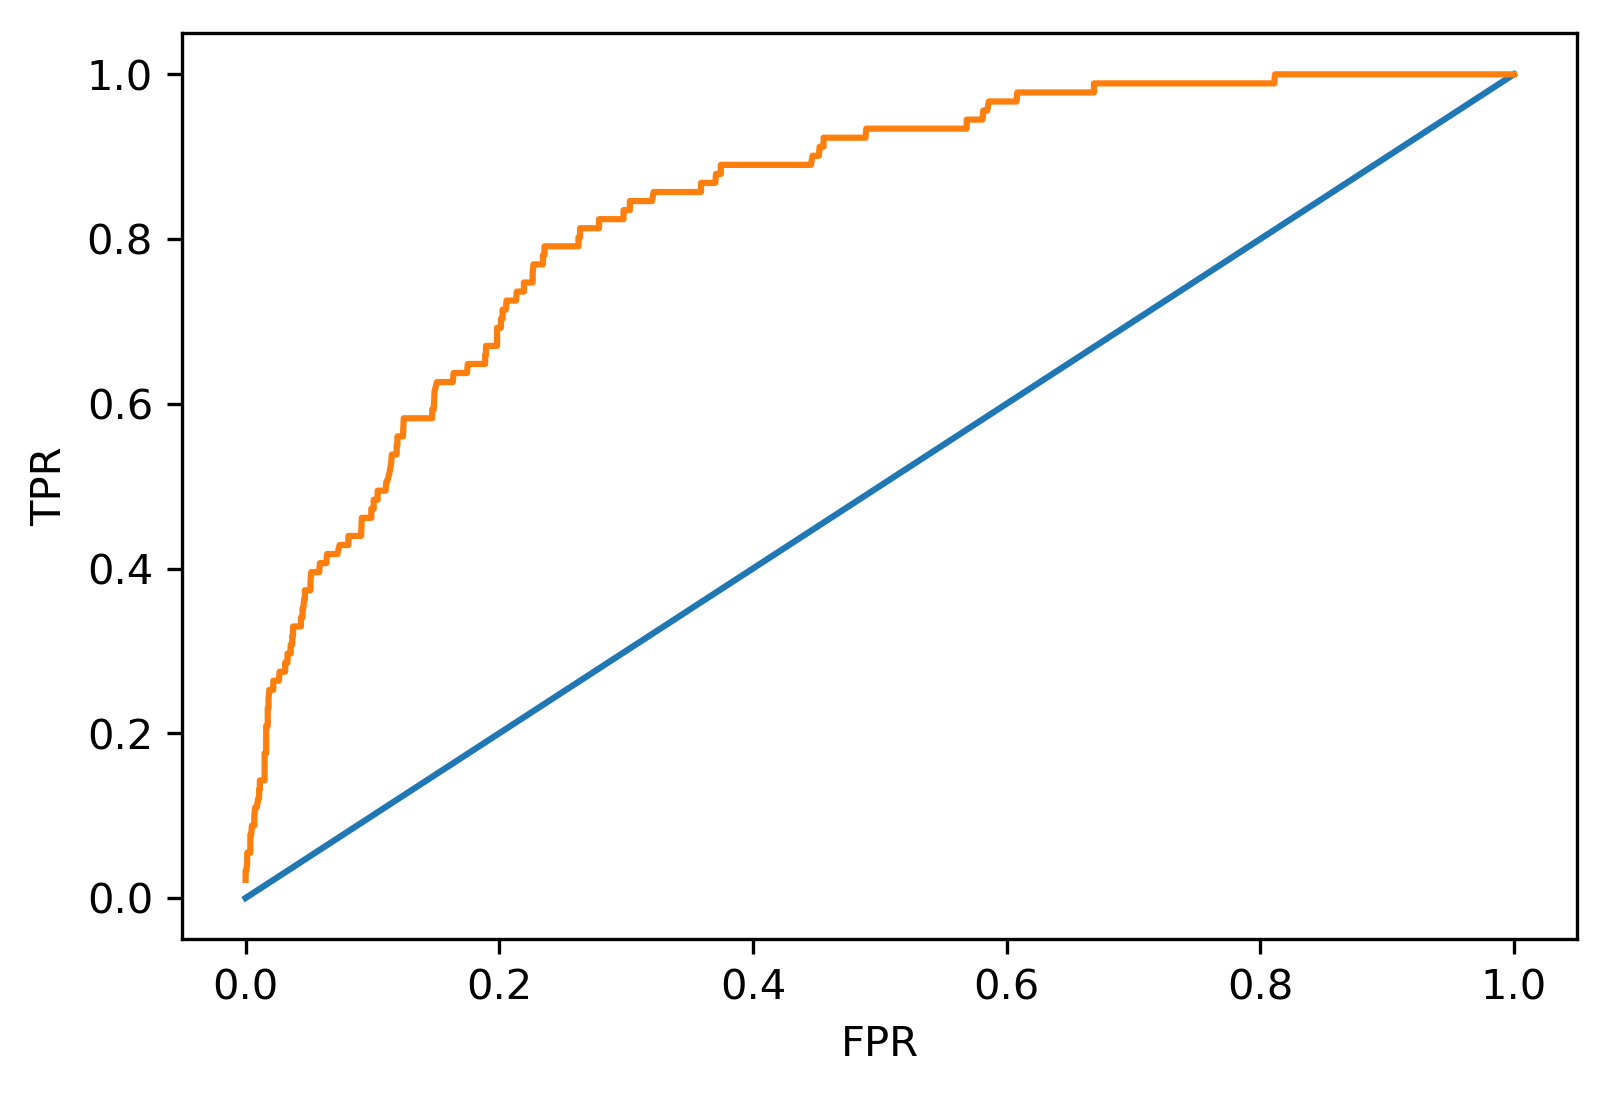

In [144]:
from sklearn.metrics import roc_curve, auc
from sklearn import cross_validation
from sklearn import metrics

xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(Xt, yt, test_size=0.2, random_state=1234)
y_score=model.predict_proba(Xhold)[:,1]

fpr, tpr,_ = roc_curve(yhold, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

In [163]:
import pickle
#
model.save_model("WNVcatboost_model", format="cbm", export_parameters=None)

In [167]:
from catboost import CatBoostClassifier
fname = "WNVcatboost_model"
sss = CatBoostClassifier()
loaded_model = sss.load_model(fname)
pred1 = loaded_model.predict(Xhold)#,prediction_type='Class')
roc_auc_score(yhold, pred1)

0.7718135978734482

In [165]:
pred1

array([1., 0., 0., ..., 1., 0., 0.])

## Model on whole dataset

In [22]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3,stratify=yt)
model = CatBoostClassifier(eval_metric="AUC",iterations=100, depth=7, learning_rate=0.1,
                           class_weights = [1, 18.06],)
model.fit(
    xtrain, ytrain,
    cat_features=categorical_features_indices,
    eval_set=(xtest, ytest),
#     logging_level='Verbose',  # you can uncomment this for text output
#    plot=True
);

0:	learn: 0.8137580	test: 0.8030926	best: 0.8030926 (0)	total: 84ms	remaining: 8.32s
1:	learn: 0.8347568	test: 0.8387456	best: 0.8387456 (1)	total: 156ms	remaining: 7.64s
2:	learn: 0.8459461	test: 0.8426564	best: 0.8426564 (2)	total: 235ms	remaining: 7.61s
3:	learn: 0.8408352	test: 0.8386600	best: 0.8426564 (2)	total: 366ms	remaining: 8.77s
4:	learn: 0.8462130	test: 0.8441871	best: 0.8441871 (4)	total: 466ms	remaining: 8.85s
5:	learn: 0.8720850	test: 0.8883203	best: 0.8883203 (5)	total: 544ms	remaining: 8.52s
6:	learn: 0.8711640	test: 0.8864619	best: 0.8883203 (5)	total: 586ms	remaining: 7.79s
7:	learn: 0.8753751	test: 0.8903301	best: 0.8903301 (7)	total: 695ms	remaining: 7.99s
8:	learn: 0.8772055	test: 0.8907616	best: 0.8907616 (8)	total: 827ms	remaining: 8.36s
9:	learn: 0.8853147	test: 0.9030719	best: 0.9030719 (9)	total: 932ms	remaining: 8.38s
10:	learn: 0.8869341	test: 0.9006889	best: 0.9030719 (9)	total: 1.08s	remaining: 8.73s
11:	learn: 0.8867433	test: 0.9002951	best: 0.9030719 (

95:	learn: 0.9228799	test: 0.9471004	best: 0.9476469 (78)	total: 8.43s	remaining: 351ms
96:	learn: 0.9248970	test: 0.9483407	best: 0.9483407 (96)	total: 8.54s	remaining: 264ms
97:	learn: 0.9252370	test: 0.9484598	best: 0.9484598 (97)	total: 8.65s	remaining: 177ms
98:	learn: 0.9252379	test: 0.9484598	best: 0.9484598 (97)	total: 8.72s	remaining: 88.1ms
99:	learn: 0.9252376	test: 0.9484598	best: 0.9484598 (97)	total: 8.81s	remaining: 0us

bestTest = 0.9484598053
bestIteration = 97

Shrink model to first 98 iterations.


In [23]:
cv_data = cv(
    Pool(X, y, cat_features=categorical_features_indices),
    model.get_params(),
    stratified=True,
    nfold=8,
    plot=True
)

0:	learn: 0.7838254	test: 0.7755347	best: 0.7755347 (0)	total: 388ms	remaining: 38.4s
1:	learn: 0.8069065	test: 0.7976937	best: 0.7976937 (1)	total: 800ms	remaining: 39.2s


MetricVisualizer(data={'catboost_info': {'path': 'catboost_info', 'name': 'catboost_info', 'content': {'passed_iterations': 1, 'total_iterations': 100, 'data': {'iterations': [{'fold_2_test': [0.7753259576, 0.6616802906], 'fold_0_learn': [0.777940502, 0.6544521188], 'fold_1_learn': [0.7800355661, 0.6541085619], 'iteration': 0, 'remaining_time': 38.37729697, 'fold_0_test': [0.78562979, 0.6557549529], 'fold_1_test': [0.7656483612, 0.6560209991], 'passed_time': 0.3876494643, 'fold_2_learn': [0.7935001665, 0.6576713277]}, {'fold_2_test': [0.7879151507, 0.6326833135], 'fold_0_learn': [0.8123778665, 0.6182774035], 'fold_1_learn': [0.8023106418, 0.6240994111], 'iteration': 1, 'remaining_time': 39.18355931, 'fold_0_test': [0.8127063148, 0.6209069926], 'fold_1_test': [0.7924595282, 0.6274002254], 'passed_time': 0.7996644757, 'fold_2_learn': [0.8060310462, 0.6275187932]}], 'meta': {'launch_mode': 'CV', 'name': 'experiment', 'iteration_count': 100, 'learn_metrics': [{'best_value': 'Max', 'name': 'AUC'}, {'best_value': 'Min', 'name': 'Logloss'}], 'test_sets': ['fold_0_test', 'fold_1_test', 'fold_2_test'], 'test_metrics': [{'best_value': 'Max', 'name': 'AUC'}, {'best_value': 'Min', 'name': 'Logloss'}], 'learn_sets': ['fold_0_learn', 'fold_1_learn', 'fold_2_learn']}}}}}, layout=Layout(align_self='stretch', height='500px'))

2:	learn: 0.8274075	test: 0.8193537	best: 0.8193537 (2)	total: 1.33s	remaining: 43.1s
3:	learn: 0.8317620	test: 0.8294450	best: 0.8294450 (3)	total: 1.83s	remaining: 44s
4:	learn: 0.8311866	test: 0.8303306	best: 0.8303306 (4)	total: 2.25s	remaining: 42.7s
5:	learn: 0.8339301	test: 0.8317770	best: 0.8317770 (5)	total: 2.61s	remaining: 40.8s
6:	learn: 0.8354467	test: 0.8335814	best: 0.8335814 (6)	total: 3.05s	remaining: 40.5s
7:	learn: 0.8447241	test: 0.8504806	best: 0.8504806 (7)	total: 3.41s	remaining: 39.2s
8:	learn: 0.8505103	test: 0.8597095	best: 0.8597095 (8)	total: 3.8s	remaining: 38.4s
9:	learn: 0.8571320	test: 0.8701191	best: 0.8701191 (9)	total: 4.2s	remaining: 37.8s
10:	learn: 0.8602183	test: 0.8742629	best: 0.8742629 (10)	total: 4.53s	remaining: 36.6s
11:	learn: 0.8628135	test: 0.8777907	best: 0.8777907 (11)	total: 4.87s	remaining: 35.7s
12:	learn: 0.8639665	test: 0.8772472	best: 0.8777907 (11)	total: 5.33s	remaining: 35.7s
13:	learn: 0.8668340	test: 0.8785169	best: 0.8785169

96:	learn: 0.9056426	test: 0.9254962	best: 0.9254962 (96)	total: 32.5s	remaining: 1s
97:	learn: 0.9056428	test: 0.9254962	best: 0.9254962 (96)	total: 33.1s	remaining: 675ms
98:	learn: 0.9056656	test: 0.9254962	best: 0.9254962 (96)	total: 33.3s	remaining: 337ms
99:	learn: 0.9061166	test: 0.9254737	best: 0.9254962 (96)	total: 33.9s	remaining: 0us


In [24]:
np.mean(cv_data['test-AUC-mean'])


0.9029353503311404

In [25]:
ypred = model.predict_proba(merged2_test)
#ypred = abs(1-ypred)
sample = pd.read_csv('../input/sampleSubmission.csv')
sample['WnvPresent'] = ypred

sample.to_csv('first_try.csv', index=False)

In [26]:
sample

,Id,WnvPresent
0,1,0.981782
1,2,0.988408
2,3,0.976707
3,4,0.990365
4,5,0.990353
5,6,0.992672
6,7,0.991424
7,8,0.996203
8,9,0.987528
9,10,0.991041


In [27]:
pred = model.predict(Xhold)
roc_auc_score(yhold, pred)

0.8231918886752724

Text(0,0.5,'TPR')

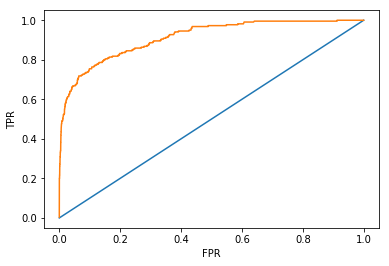

In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn import cross_validation
from sklearn import metrics

xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(Xt, yt, test_size=0.2, random_state=1234)
y_score=model.predict_proba(Xhold)[:,1]

fpr, tpr,_ = roc_curve(yhold, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

In [779]:
len(Xt.columns)

15

In [711]:
#xtrain, xtest, ytrain, ytest = train_test_split(Xt, yt, test_size=0.3)
linearsvc = LinearSVC()
decisiontree = DecisionTreeClassifier()
randomforest = RandomForestClassifier()
blagging = BaggingClassifier()
log = LogisticRegression()
dummy = DummyClassifier()
# fit = randomforest.fit(xtrain, ytrain)
# pred = fit.predict(xtest)
cohens_few_times(log, Xt, yt)

0.024967278133334412

In [703]:
quick_test(dummy, Xt, yt)

0.8933386201427439

In [443]:
randomforest = RandomForestClassifier()
quick_test_afew_times(randomforest, X, y)
f1_test(randomforest,X,y)

0.15458937198067632

In [444]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model_svm = svm.SVC(kernel='rbf', gamma = 0.001)
model_svm.fit(X_train, y_train)
y_pred = model_svm.predict(X_test)
f1_test(svm.SVC(kernel='rbf', gamma = 0.001),X,y)

/Users/petermin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

Text(0,0.5,'TPR')

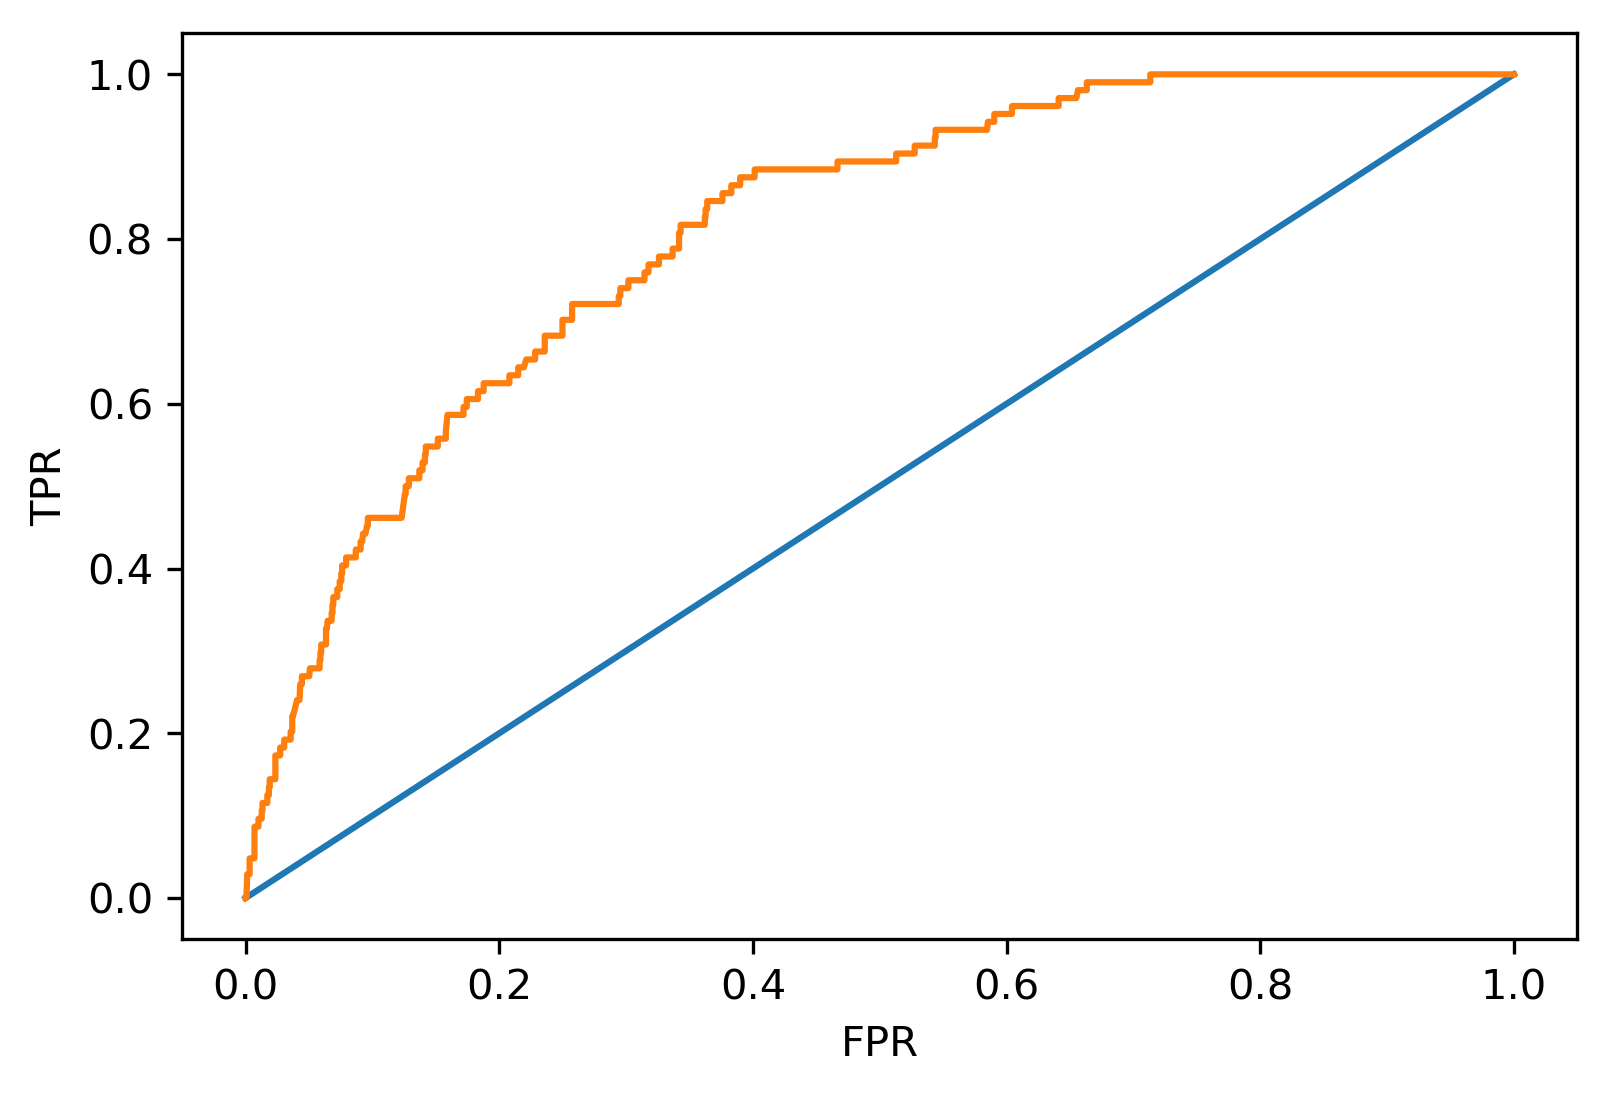

In [611]:
from sklearn.metrics import roc_curve, auc
from patsy import dmatrices

from sklearn import linear_model as lm
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import confusion_matrix

xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(Xt, yt, test_size=0.2, random_state=1234)
log = LogisticRegression()
log.fit(xtrain,np.ravel(ytrain))
y_score=log.predict_proba(xtest)[:,1]

fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

In [446]:
# Generate a confusion matrix plot: 

def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Could be a typical function for classifying:

def train_score(classifier,x,y):
    xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(x, y, test_size=0.2, random_state=1234)
    ytrain=np.ravel(ytrain)
    clf = classifier.fit(xtrain, ytrain)
    # accuracy for test & train:
    train_acc=clf.score(xtrain, ytrain)
    test_acc=clf.score(xtest,ytest)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))
    
    y_true = ytest
    y_pred = clf.predict(xtest)


    conf = confusion_matrix(y_true, y_pred)
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
    print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
    
    cm=confusion_matrix(y_true, y_pred, labels=None)
    
    plt.figure()
    plot_confusion_matrix(cm)

In [453]:
from sklearn.metrics import f1_score
log_clf=LogisticRegression()
randomforest = RandomForestClassifier()
linearsvc = LinearSVC()
dummy = DummyClassifier()
f1_test(randomforest, Xt, yt)

0.17894736842105263

# Feature Importance

Feature ranking:
1. feature 10 (0.049720)
2. feature 9 (0.042792)
3. feature 1 (0.035133)
4. feature 3 (0.033249)
5. feature 14 (0.032886)
6. feature 13 (0.031793)
7. feature 2 (0.030062)
8. feature 5 (0.028482)
9. feature 4 (0.027488)
10. feature 6 (0.026922)
11. feature 8 (0.026507)
12. feature 100 (0.019069)
13. feature 30 (0.018896)
14. feature 61 (0.017155)
15. feature 11 (0.017126)
16. feature 153 (0.016813)
17. feature 15 (0.015564)
18. feature 87 (0.014664)
19. feature 20 (0.014044)
20. feature 26 (0.013690)
21. feature 39 (0.012702)
22. feature 28 (0.012347)
23. feature 38 (0.012335)
24. feature 21 (0.012092)
25. feature 149 (0.011877)
26. feature 120 (0.011707)
27. feature 41 (0.011323)
28. feature 145 (0.010961)
29. feature 40 (0.010693)
30. feature 101 (0.010393)
31. feature 0 (0.010368)
32. feature 80 (0.009358)
33. feature 108 (0.009313)
34. feature 102 (0.008895)
35. feature 104 (0.008813)
36. feature 143 (0.008742)
37. feature 58 (0.008470)
38. feature 29 (0.008240)
39.

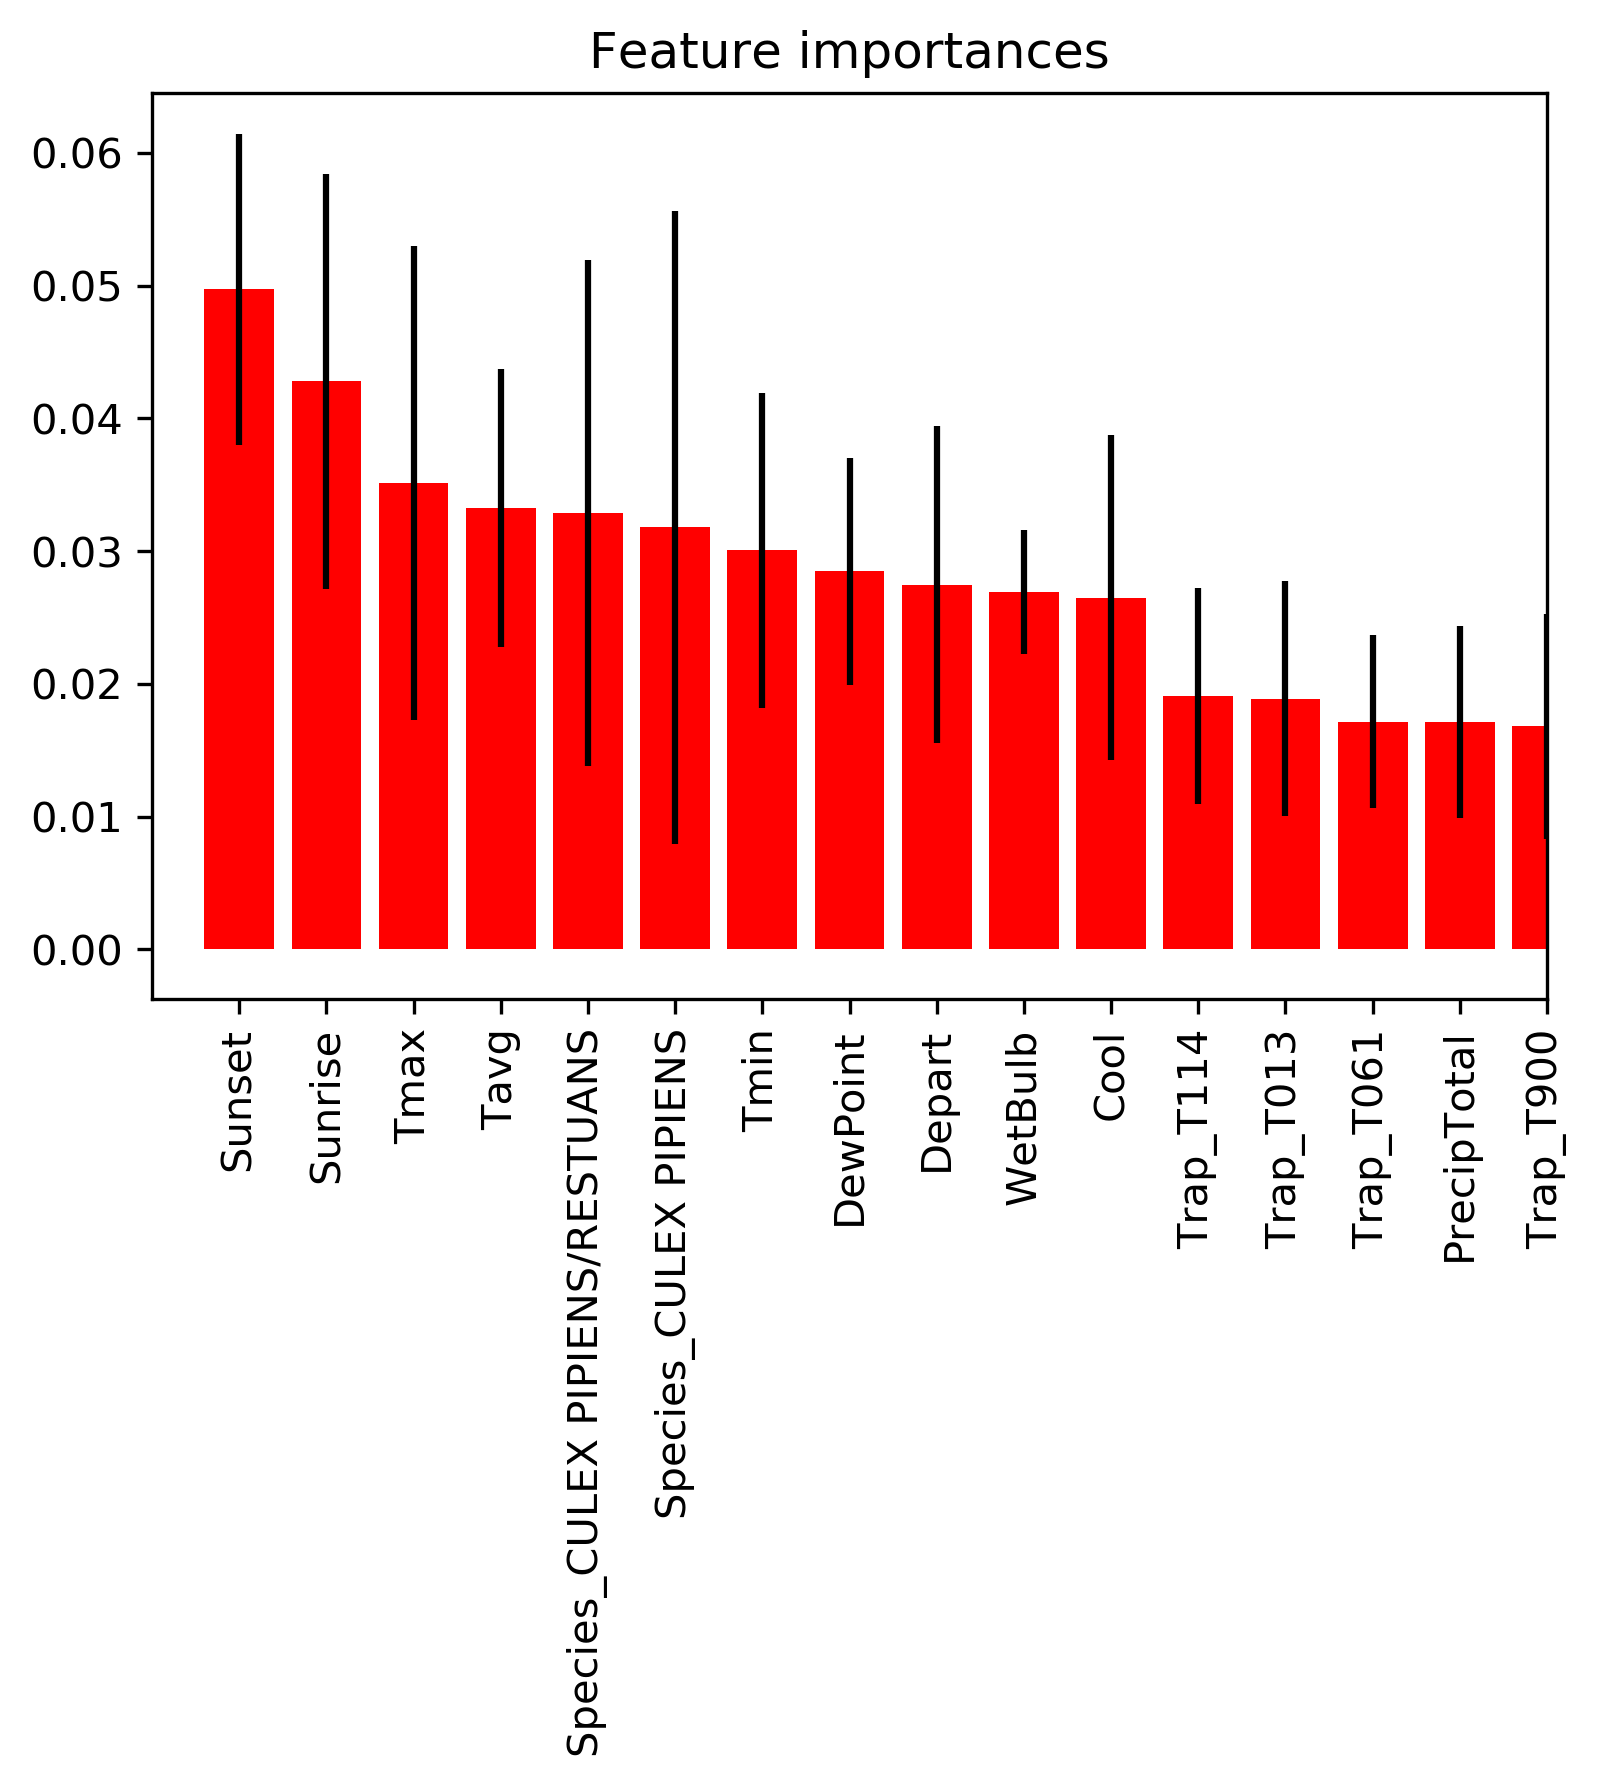

In [468]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
randomforest.fit(xtrain, ytrain)
importances = randomforest.feature_importances_
std = np.std([tree.feature_importances_ for tree in randomforest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(xtrain.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(xtrain.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(xtrain.shape[1]), xtrain.columns[indices], rotation="vertical")
plt.xlim([-1, 15])
plt.show()

In [474]:
xtrain.columns[0]

'Station'

# Time series analysis (figuring out time lag)

In [475]:
#Depart, Cool, Sunrise & Sunset, and PrecipTotal have Missing values
weather.Tavg.unique()

array([67., 68., 51., 52., 56., 58., 60., 59., 65., 70., 69., 71., 61.,
       55., 57., 73., 72., 53., 62., 63., 74., 75., 78., 76., 77., 66.,
       80., 64., 81., 82., 79., 85., 84., 83., 50., 49., 46., 48., 45.,
       54., 47., 44., 40., 41., 38., 39., 42., 37., 43., 86., 87., 89.,
       92., 88., 91., 93., 94., 90., 36.])

In [476]:
traps.columns

Index(['Date', 'Species', 'Trap', 'Longitude', 'Latitude', 'NumMosquitos',
       'WnvPresent'],
      dtype='object')

In [504]:
traps_2009 = traps[(traps.Date < dt.date(2010,1,1)) & (traps.Date > dt.date(2009,1,1))]
weather_2009 = weather[(weather.Date < dt.date(2010,1,1)) & (weather.Date > dt.date(2009,1,1))]
traps_2011 = traps[(traps.Date < dt.date(2012,1,1)) & (traps.Date > dt.date(2011,1,1))]
weather_2011 = weather[(weather.Date < dt.date(2012,1,1)) & (weather.Date > dt.date(2011,1,1))]

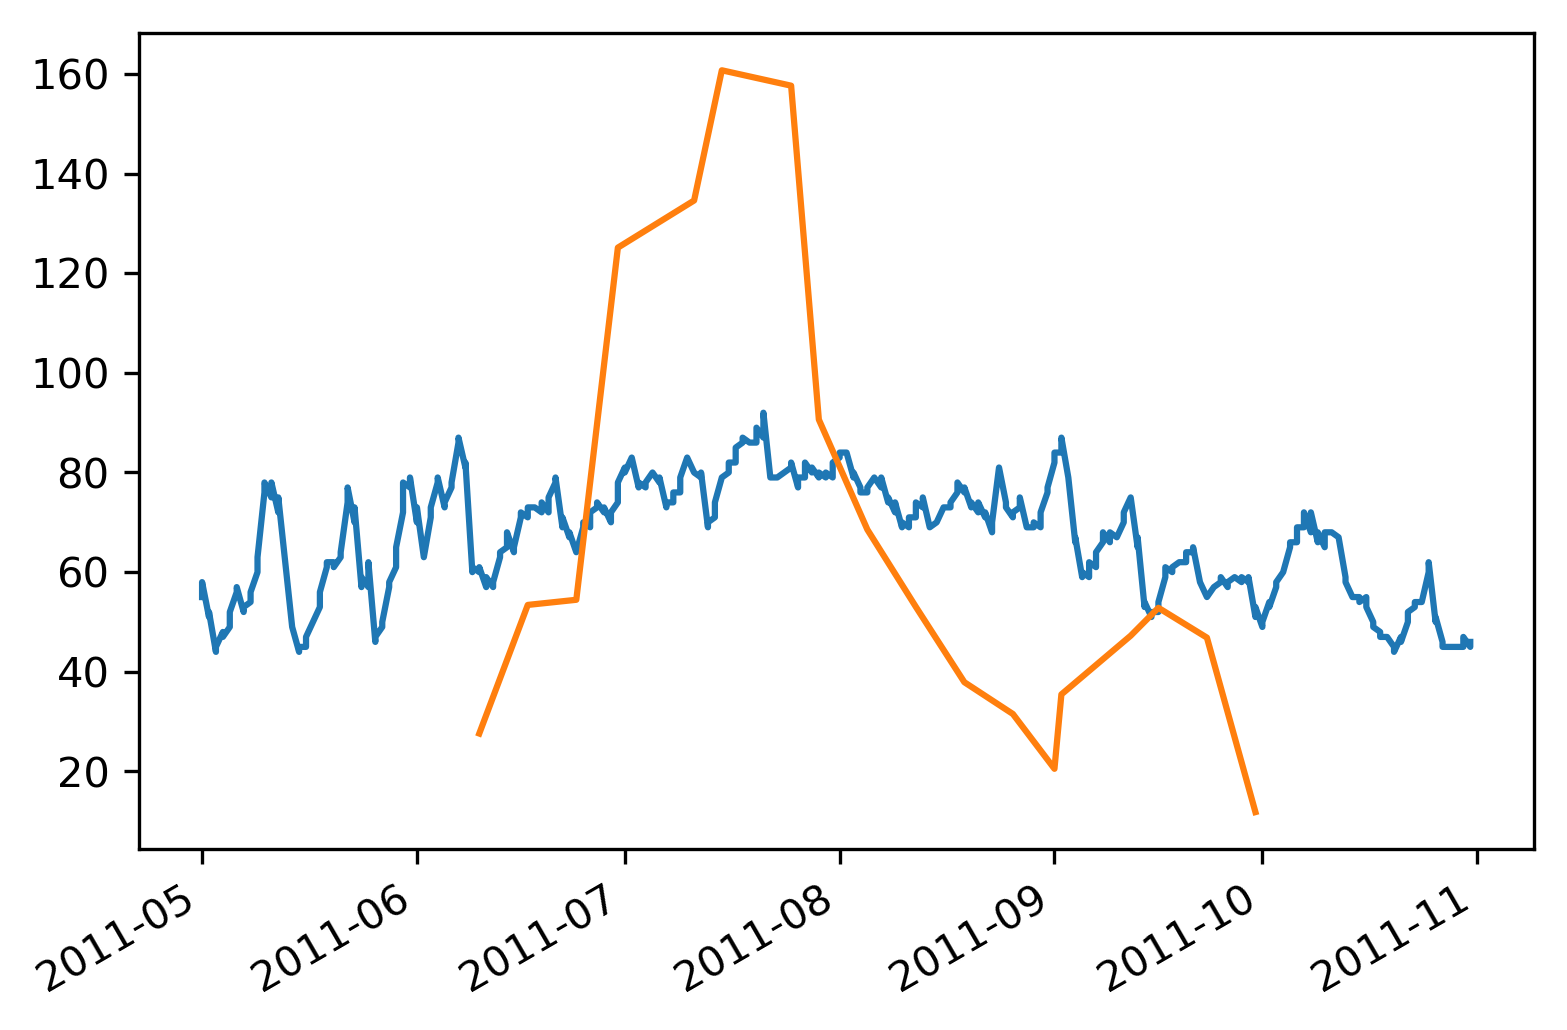

In [478]:
# dates = dates.date2num(weather.Date)
# plt.plot_date(dates, weather.Tavg)
plt.plot(weather[(weather.Date < dt.date(2012,1,1)) & 
                 (weather.Date > dt.date(2011,1,1))].Date,
        weather[(weather.Date < dt.date(2012,1,1)) & 
                (weather.Date > dt.date(2011,1,1))].Tavg)

plt.plot(traps_2011.groupby('Date').agg('sum').index, 
         traps_2011.groupby('Date').agg('sum').NumMosquitos/Scale)
plt.gcf().autofmt_xdate()

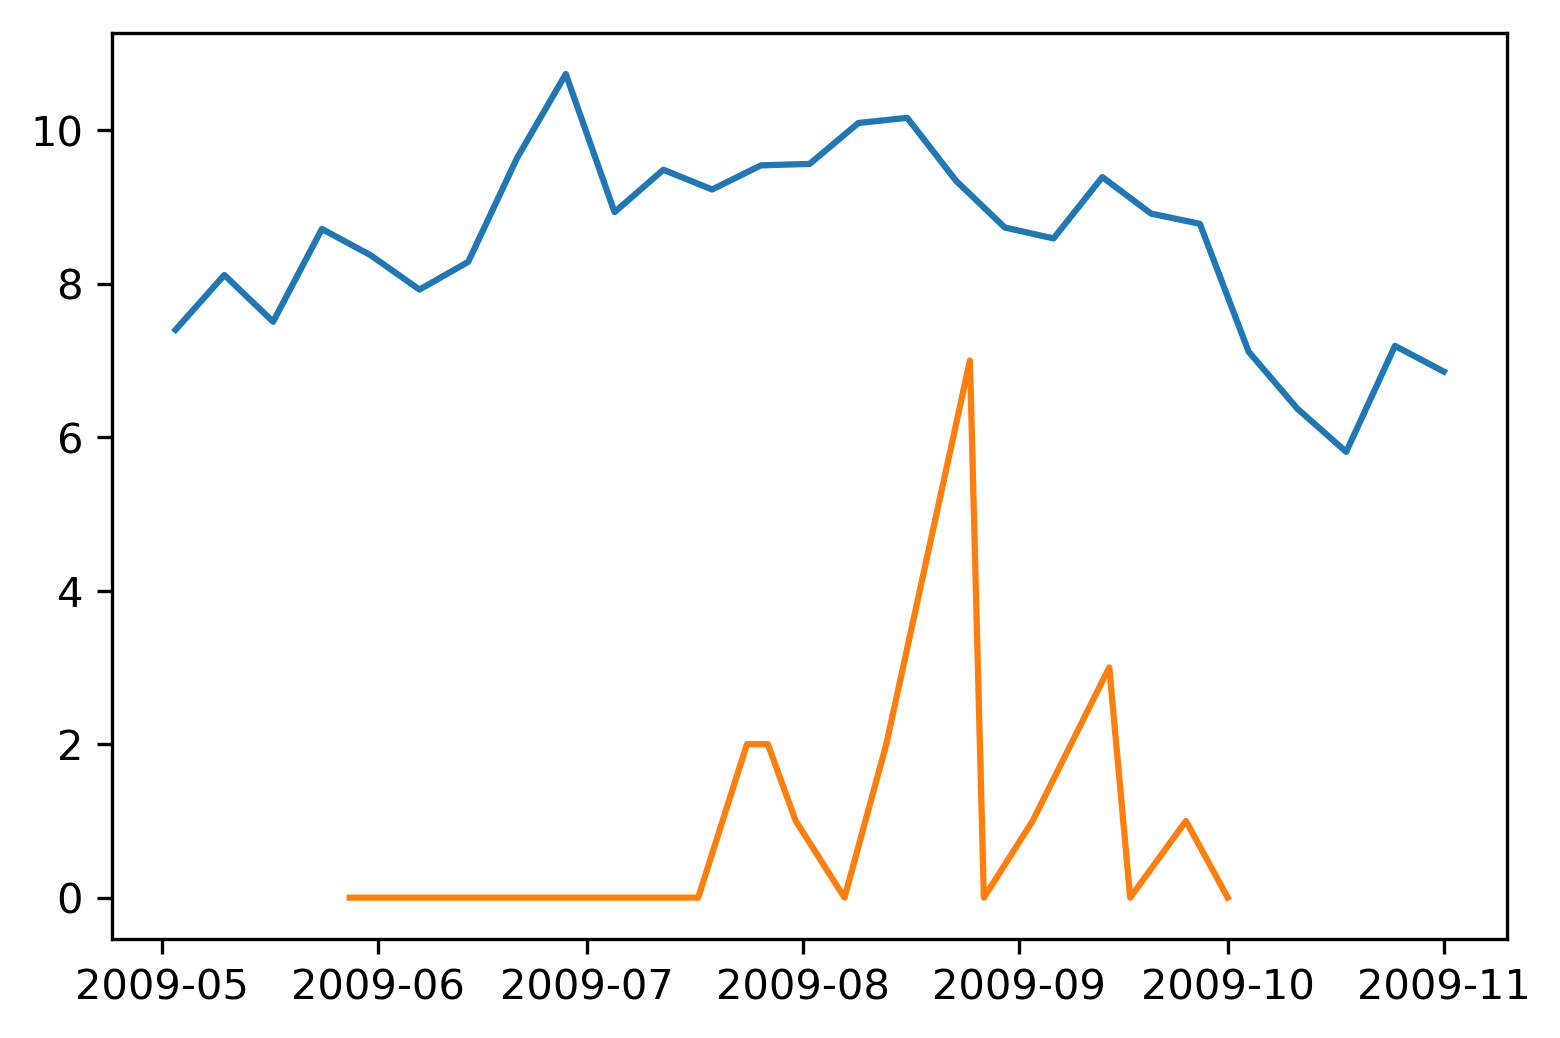

In [506]:
weekly_2009 = weather_2009.set_index("Date").Tavg.resample('W').mean()
plt.plot(weekly_2009 / 7.5)
plt.plot(traps_2009.groupby('Date').agg('sum').index, 
         traps_2009.groupby('Date').agg('sum').WnvPresent)


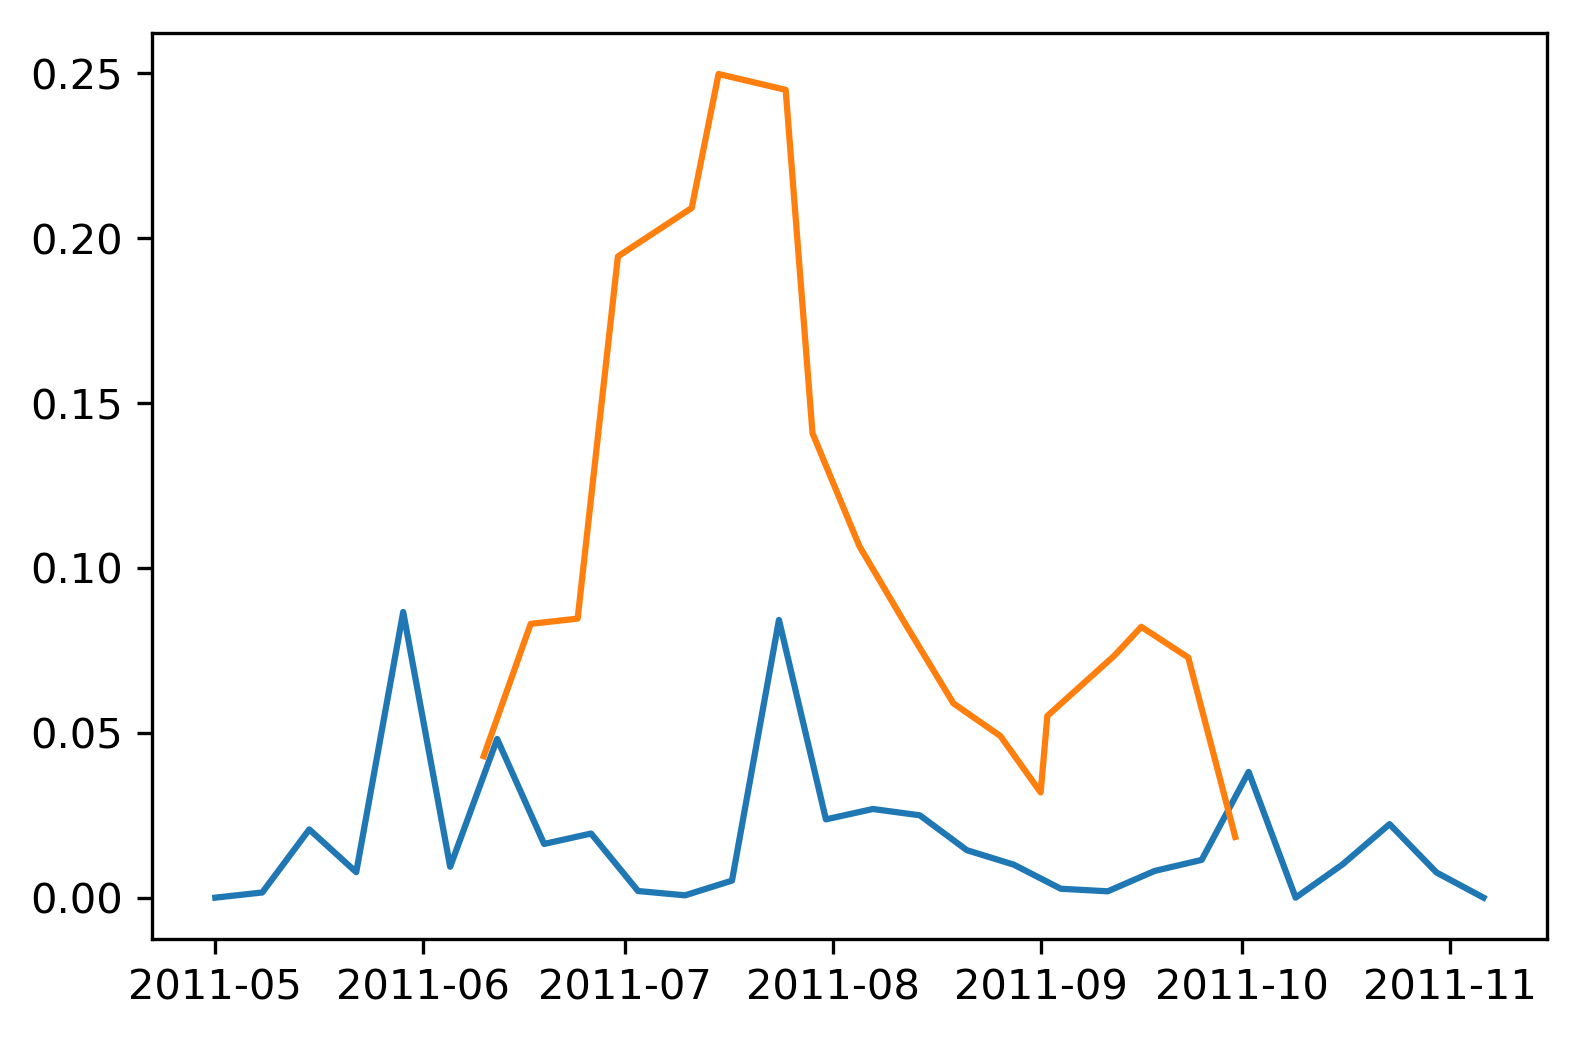

In [556]:
weekly_2011 = weather_2011.set_index("Date").PrecipTotal.resample('W').mean()
plt.plot(weekly_2011 / 7.5)
plt.plot(traps_2011.groupby('Date').agg('sum').index, 
         traps_2011.groupby('Date').agg('sum').NumMosquitos/10000)


In [495]:

#weather2 = weather.set_index("Date")
weathermax_2011 = weather_2011.set_index("Date").Tavg.resample('W').mean().max()
trapsmax_2011 = traps_2011.groupby('Date').agg('sum').WnvPresent.max()
weathermax_2011

83.92857142857143

In [549]:
weather_2011.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'PrecipTotal'],
      dtype='object')

In [494]:
#traps_2011[traps_2011.groupby('Date').agg('sum').WnvPresent == trapsmax_2011]
#traps_2011.groupby('Date').agg('sum').WnvPresent
weather_2011.set_index("Date").Tavg.resample('W').mean()

Date
2011-05-01    56.500000
2011-05-08    51.142857
2011-05-15    63.428571
2011-05-22    58.928571
2011-05-29    57.928571
2011-06-05    73.071429
2011-06-12    68.857143
2011-06-19    69.142857
2011-06-26    70.500000
2011-07-03    76.285714
2011-07-10    77.857143
2011-07-17    77.857143
2011-07-24    83.928571
2011-07-31    80.000000
2011-08-07    79.571429
2011-08-14    71.785714
2011-08-21    73.785714
2011-08-28    72.785714
2011-09-04    75.785714
2011-09-11    64.928571
2011-09-18    59.928571
2011-09-25    59.714286
2011-10-02    55.500000
2011-10-09    65.428571
2011-10-16    60.500000
2011-10-23    48.500000
2011-10-30    49.571429
2011-11-06    45.500000
Freq: W-SUN, Name: Tavg, dtype: float64

In [503]:
dt.date(2011,8,14)-dt.date(2011,7,24)

datetime.timedelta(21)

In [501]:
tweekly_2011 = traps_2011.groupby('Date').agg('sum').WnvPresent.resample('W', fill_method='ffill')
tweekly_2011

/Users/petermin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill()
  """Entry point for launching an IPython kernel.


Date
2011-06-12     0
2011-06-19     0
2011-06-26     0
2011-07-03     0
2011-07-10     0
2011-07-17     0
2011-07-24     0
2011-07-31     8
2011-08-07     5
2011-08-14    11
2011-08-21     4
2011-08-28     4
2011-09-04     3
2011-09-11     3
2011-09-18     3
2011-09-25     6
2011-10-02     0
Freq: W-SUN, Name: WnvPresent, dtype: int64

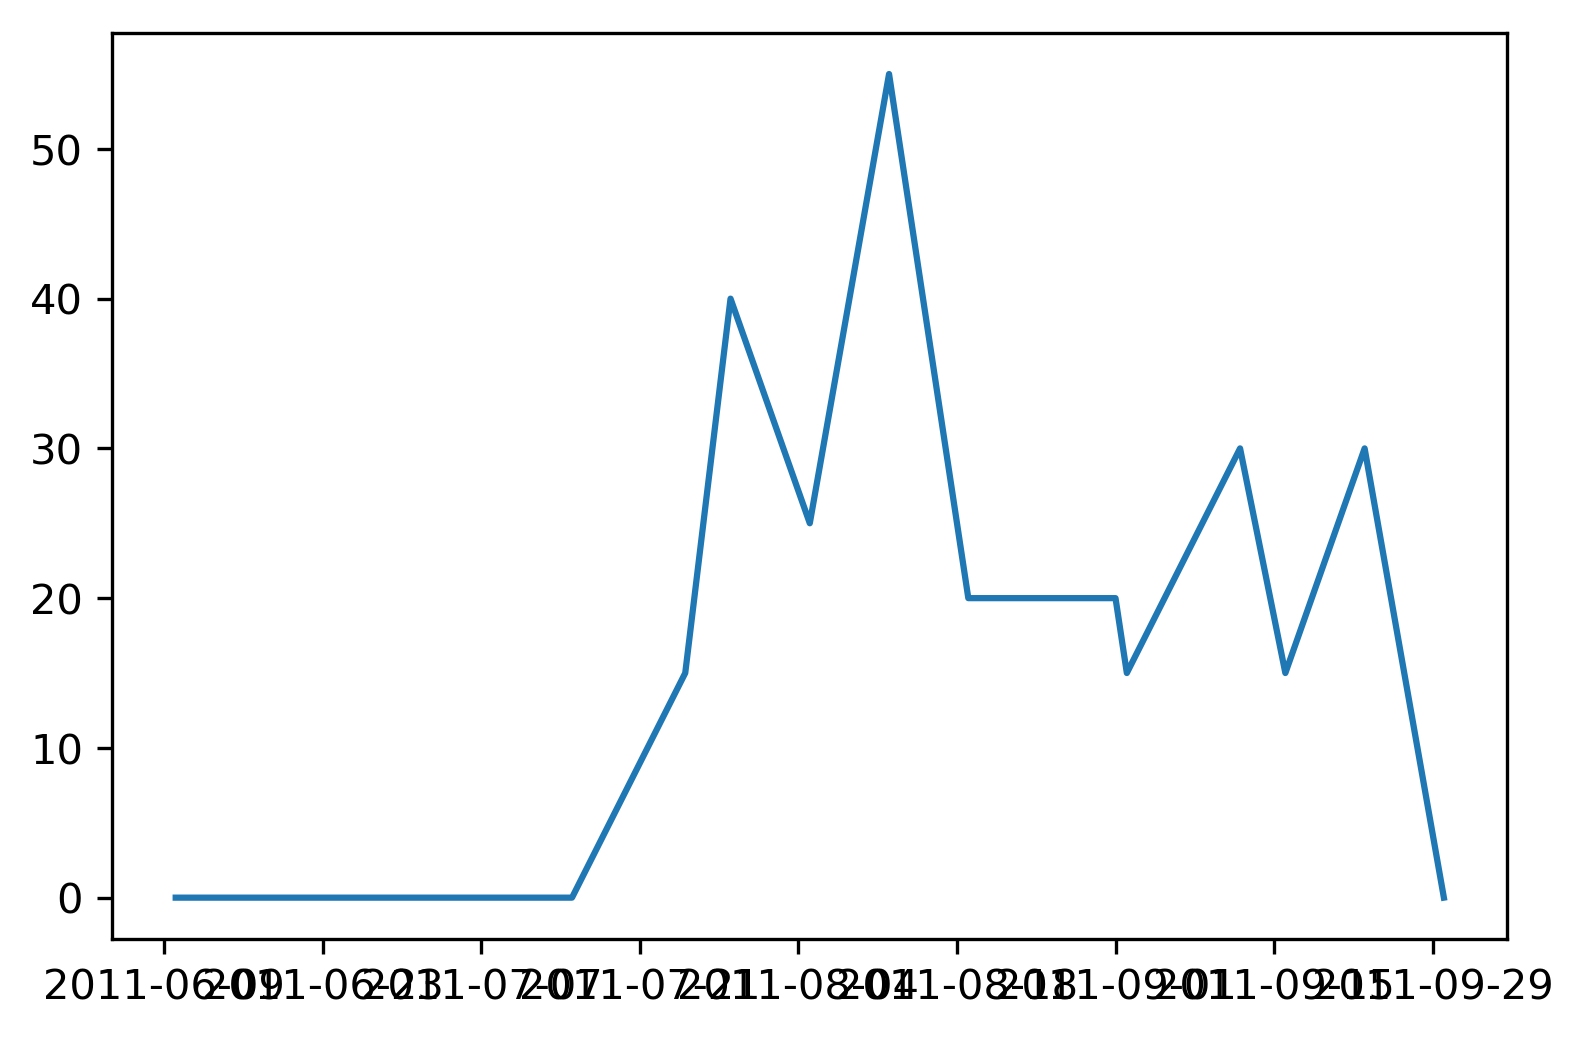

In [331]:
plt.plot(traps_2011.groupby('Date').agg('sum').index, 
         traps_2011.groupby('Date').agg('sum').WnvPresent*5)

In [110]:
traps_2011.groupby('Date').agg('sum').index, traps_2011.groupby('Date').agg('sum').WnvPresent

(DatetimeIndex(['2011-06-10', '2011-06-17', '2011-06-24', '2011-06-30',
                '2011-07-11', '2011-07-15', '2011-07-25', '2011-07-29',
                '2011-08-05', '2011-08-12', '2011-08-19', '2011-08-26',
                '2011-09-01', '2011-09-02', '2011-09-12', '2011-09-16',
                '2011-09-23', '2011-09-30'],
               dtype='datetime64[ns]', name='Date', freq=None), Date
 2011-06-10     0
 2011-06-17     0
 2011-06-24     0
 2011-06-30     0
 2011-07-11     0
 2011-07-15     0
 2011-07-25     3
 2011-07-29     8
 2011-08-05     5
 2011-08-12    11
 2011-08-19     4
 2011-08-26     4
 2011-09-01     4
 2011-09-02     3
 2011-09-12     6
 2011-09-16     3
 2011-09-23     6
 2011-09-30     0
 Name: WnvPresent, dtype: int64)

In [111]:
traps_2011.groupby('Date').agg('sum').WnvPresent

Date
2011-06-10     0
2011-06-17     0
2011-06-24     0
2011-06-30     0
2011-07-11     0
2011-07-15     0
2011-07-25     3
2011-07-29     8
2011-08-05     5
2011-08-12    11
2011-08-19     4
2011-08-26     4
2011-09-01     4
2011-09-02     3
2011-09-12     6
2011-09-16     3
2011-09-23     6
2011-09-30     0
Name: WnvPresent, dtype: int64

In [77]:
weather[(weather.Date < dt.date(2010,1,1)) & (weather.Date > dt.date(2009,1,1))].Date.head()

736   2009-05-01
737   2009-05-01
738   2009-05-02
739   2009-05-02
740   2009-05-03
Name: Date, dtype: datetime64[ns]

In [216]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [79]:
traps_2009.groupby('Date').agg('sum').index

DatetimeIndex(['2009-05-28', '2009-06-02', '2009-06-03', '2009-06-05',
               '2009-06-12', '2009-06-15', '2009-06-19', '2009-06-22',
               '2009-06-26', '2009-06-29', '2009-07-06', '2009-07-10',
               '2009-07-13', '2009-07-17', '2009-07-24', '2009-07-27',
               '2009-07-31', '2009-08-07', '2009-08-13', '2009-08-25',
               '2009-08-27', '2009-09-03', '2009-09-14', '2009-09-17',
               '2009-09-25', '2009-10-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [116]:
# import numpy as np
# from scipy.interpolate import Rbf, InterpolatedUnivariateSpline

# import matplotlib
# matplotlib.use('Agg')
# import matplotlib.pyplot as plt

# # xi = weather[(weather.Date < dt.date(2012,1,1)) & (weather.Date > dt.date(2011,1,1))].Tavg
# # # use fitpack2 method
# # ius = InterpolatedUnivariateSpline(weather[(weather.Date < dt.date(2012,1,1)) & (weather.Date > dt.date(2011,1,1))].Date,
# #         weather[(weather.Date < dt.date(2012,1,1)) & (weather.Date > dt.date(2011,1,1))].Tavg)
# # yi = ius(xi)

# # import statsmodels.api as sm
# # sm.tsa.seasonal_decompose(weather[(weather.Date < dt.date(2012,1,1)) & (weather.Date > dt.date(2011,1,1))].Tavg).plot()
# # result = sm.tsa.stattools.adfuller(weather[(weather.Date < dt.date(2012,1,1)) & (weather.Date > dt.date(2011,1,1))].Date)
# # plt.show()
# Tavg = weather[(weather.Date < dt.date(2012,1,1)) & (weather.Date > dt.date(2011,1,1))].Tavg
# Date = weather[(weather.Date < dt.date(2012,1,1)) & (weather.Date > dt.date(2011,1,1))].Date
# Date.corr(Tavg)